FROM https://github.com/tensorflow/models/blob/master/slim/slim_walkthrough.ipynb

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import tensorflow.contrib as slim
import time

In [2]:
def regression_model(inputs, is_training=True, scope="deep_regression"):
    """Creates the regression model.

    Args:
        inputs: A node that yields a `Tensor` of size [batch_size, dimensions].
        is_training: Whether or not we're currently training the model.
        scope: An optional variable_op scope for the model.

    Returns:
        predictions: 1-D `Tensor` of shape [batch_size] of responses.
        end_points: A dict of end points representing the hidden layers.
    """
    with tf.variable_scope(scope, 'deep_regression', [inputs]):
        end_points = {}
        # Set the default weight _regularizer and acvitation for each fully_connected layer.
        with slim.arg_scope([slim.fully_connected],
                            activation_fn=tf.nn.relu,
                            weights_regularizer=slim.l2_regularizer(0.01)):

            # Creates a fully connected layer from the inputs with 32 hidden units.
            net = slim.fully_connected(inputs, 32, scope='fc1')
            end_points['fc1'] = net

            # Adds a dropout layer to prevent over-fitting.
            net = slim.dropout(net, 0.8, is_training=is_training)

            # Adds another fully connected layer with 16 hidden units.
            net = slim.fully_connected(net, 16, scope='fc2')
            end_points['fc2'] = net

            # Creates a fully-connected layer with a single hidden unit. Note that the
            # layer is made linear by setting activation_fn=None.
            predictions = slim.fully_connected(net, 1, activation_fn=None, scope='prediction')
            end_points['out'] = predictions

            return predictions, end_points

In [3]:
with tf.Graph().as_default():
    # Dummy placeholders for arbitrary number of 1d inputs and outputs
    inputs = tf.placeholder(tf.float32, shape=(None, 1))
    outputs = tf.placeholder(tf.float32, shape=(None, 1))

    # Build model
    predictions, end_points = regression_model(inputs)

    # Print name and shape of each tensor.
    print("Layers")
    for k, v in end_points.items():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))

    # Print name and shape of parameter nodes  (values not yet initialized)
    print("\n")
    print("Parameters")
    for v in slim.get_model_variables():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))

Layers
name = deep_regression/fc1/Relu:0, shape = (?, 32)
name = deep_regression/fc2/Relu:0, shape = (?, 16)
name = deep_regression/prediction/BiasAdd:0, shape = (?, 1)


Parameters
name = deep_regression/fc1/weights:0, shape = (1, 32)
name = deep_regression/fc1/biases:0, shape = (32,)
name = deep_regression/fc2/weights:0, shape = (32, 16)
name = deep_regression/fc2/biases:0, shape = (16,)
name = deep_regression/prediction/weights:0, shape = (16, 1)
name = deep_regression/prediction/biases:0, shape = (1,)


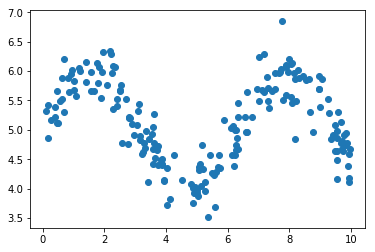

In [4]:
def produce_batch(batch_size, noise=0.3):
    xs = np.random.random(size=[batch_size, 1]) * 10
    ys = np.sin(xs) + 5 + np.random.normal(size=[batch_size, 1], scale=noise)
    return [xs.astype(np.float32), ys.astype(np.float32)]

x_train, y_train = produce_batch(200)
x_test, y_test = produce_batch(200)
plt.scatter(x_train, y_train)

In [5]:
def convert_data_to_tensors(x, y):
    inputs = tf.constant(x)
    inputs.set_shape([None, 1])
    
    outputs = tf.constant(y)
    outputs.set_shape([None, 1])
    return inputs, outputs

In [6]:
# The following snippet trains the regression model using a mean_squared_error loss.
ckpt_dir = './.checkpoints/regression_model/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    inputs, targets = convert_data_to_tensors(x_train, y_train)

    # Make the model.
    predictions, nodes = regression_model(inputs, is_training=True)

    # Add the loss function to the graph.
    loss = tf.losses.mean_squared_error(labels=targets, predictions=predictions)
    
    # The total loss is the uers's loss plus any regularization losses.
    total_loss = slim.losses.get_total_loss()

    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
    train_op = slim.learning.create_train_op(total_loss, optimizer) 

    # Run the training inside a session.
    final_loss = slim.learning.train(
        train_op,
        logdir=ckpt_dir,
        number_of_steps=5000,
        save_summaries_secs=5,
        log_every_n_steps=500)
  
print("Finished training. Last batch loss:", final_loss)
print("Checkpoint saved in %s" % ckpt_dir)

Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global step 500: loss = 0.5376 (0.00 sec/step)
INFO:tensorflow:global step 1000: loss = 0.3663 (0.00 sec/step)
INFO:tensorflow:global step 1500: loss = 0.2731 (0.00 sec/step)
INFO:tensorflow:global step 2000: loss = 0.2922 (0.00 sec/step)
INFO:tensorflow:global step 2500: loss = 0.2015 (0.00 sec/step)
INFO:tensorflow:global step 3000: loss = 0.2221 (0.00 sec/step)
INFO:tensorflow:global step 3500: loss = 0.2144 (0.00 sec/step)
INFO:tensorflow:global step 4000: loss = 0.1753 (0.00 sec/step)
INFO:tensorflow:global step 4500: loss = 0.1711 (0.00 sec/step)
INFO:tensorflow:global step 5000: loss = 0.1710 (0.00 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finish

INFO:tensorflow:Restoring parameters from ./.checkpoints/regression_model/model.ckpt-5000


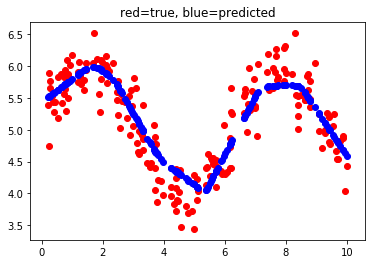

In [7]:
with tf.Graph().as_default():
    inputs, targets = convert_data_to_tensors(x_test, y_test)
  
    # Create the model structure. (Parameters will be loaded below.)
    predictions, end_points = regression_model(inputs, is_training=False)

    # Make a session which restores the old parameters from a checkpoint.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        inputs, predictions, targets = sess.run([inputs, predictions, targets])

plt.scatter(inputs, targets, c='r');
plt.scatter(inputs, predictions, c='b');
plt.title('red=true, blue=predicted')